<a href="https://colab.research.google.com/github/Fulmo/ML_ITMM/blob/master/cv_lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Список заданий:
1. Прочитать изображение из файла
2. Исходное цветное изображение преобразовать в полутоновое и улучшить контраст
3. Найти края обьекта методом Canny
4. Найти угловые точки на изображении. Нарисовать их кругом с радиусом r в тоже изображение где края
5. Для найденных границ и угловых точек строится карта расстояний методом distance transform
6. В каждом пикселе производится фильтрация усреднением. Размер фильтра для усреднения зависит от расстояния до угловых точек и краевых точек.
7. Для ускорения вычислений при усреднении нужно использовать интегральные изображения  

Info: https://www.tutorialspoint.com/opencv/index.htm

In [0]:
from google.colab.patches import cv2_imshow

import cv2 as cv

import numpy as np
import matplotlib.pyplot as plt

import copy

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# 1. Считываем изображение

In [0]:
# Считываем изображение
terry = cv.imread(r'/content/drive/My Drive/Colab Notebooks/Terry.jpg')

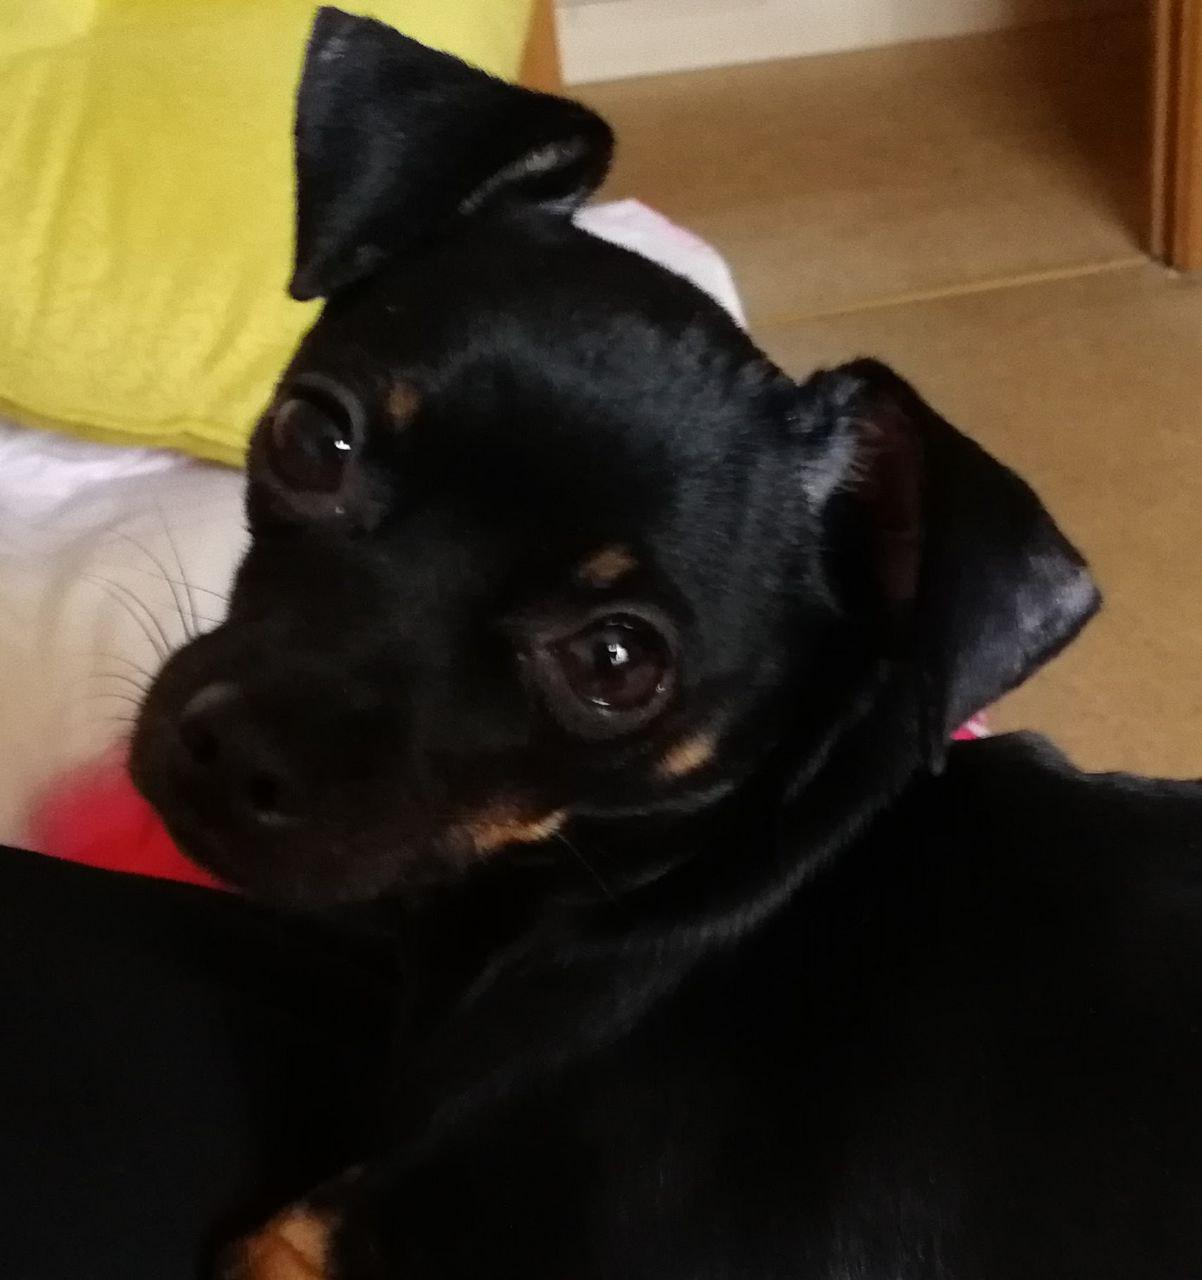

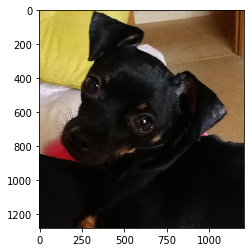

In [0]:
cv2_imshow(terry)
plt.imshow(cv.cvtColor(terry, cv.COLOR_BGR2RGB))

# 2. Преобразование в полутоновое, контрась

height:  1280 
width :  1202


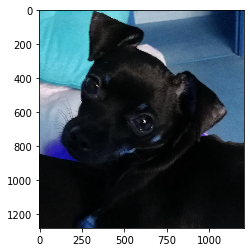

In [0]:
gray_pic = cv.cvtColor(terry, cv.COLOR_RGB2GRAY)
plt.imshow(terry, cmap='gray')
height = terry.shape[0]
width = terry.shape[1]
print('height: ', height, "\nwidth : ", width)

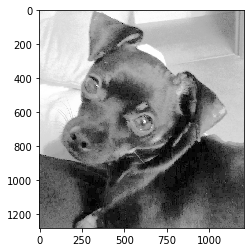

In [0]:
contrast_pic = cv.equalizeHist(gray_pic)
plt.imshow(contrast_pic, cmap='gray')

# 3. Метод Canny

In [0]:
canny_pic = cv.Canny(contrast_pic, 300, 200)
canny_pic_gray = cv.Canny(gray_pic, 300, 200)

def show_pics(one, two, color=False):
  fig, (x1, x2) = plt.subplots(1, 2)
  if (color):
      x1.imshow(one)
      x2.imshow(two)
  else:
      x1.imshow(one, cmap='gray')
      x2.imshow(two, cmap='gray')

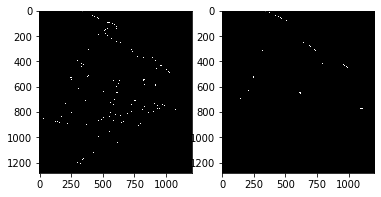

In [0]:
show_pics(canny_pic, canny_pic_gray)

# 4. Найти угловые точки, нарисовать кругом

In [0]:
def corners_drawing(picture, corners):
    for corner in corners:
        x, y = corner.ravel()
        cv.circle(picture, center=(x, y), radius=4, color=(255,69,0), thickness=-1)

def show_corners_on_pic(pic_):   
    corners = cv.goodFeaturesToTrack(copy.deepcopy(pic_), maxCorners=100, qualityLevel=0.4, minDistance=2)
    corners_pic = copy.deepcopy(pic_)
    corners_drawing(corners_pic, corners)

    return corners_pic

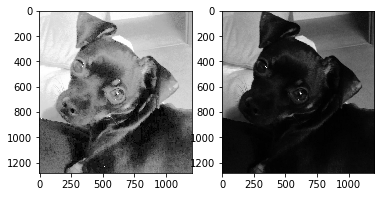

In [0]:
show_pics(show_corners_on_pic(contrast_pic), show_corners_on_pic(gray_pic))

# 5. Distance Transform

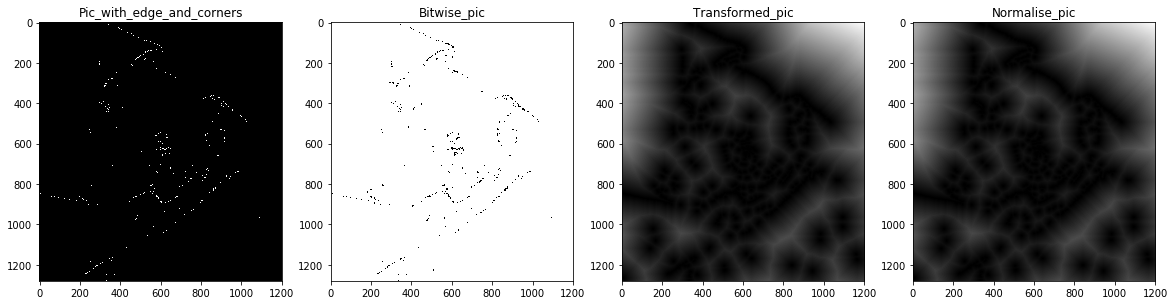

In [0]:
edges = canny_pic
fig, (x1, x2, x3, x4) = plt.subplots(1, 4, figsize=(20, 20))

pic_with_edge_and_corners = show_corners_on_pic(edges)
x1.set_title('Pic_with_edge_and_corners')
x1.imshow(canny_pic, cmap='gray')

cv.bitwise_not(pic_with_edge_and_corners, pic_with_edge_and_corners)
x2.set_title('Bitwise_pic')
x2.imshow(pic_with_edge_and_corners, cmap='gray')

distance_transform = cv.distanceTransform(pic_with_edge_and_corners, distanceType=cv.DIST_L2, maskSize=3)
x3.set_title('Transformed_pic')
x3.imshow(distance_transform, cmap='gray')

normalized_pic = distance_transform
cv.normalize(distance_transform, normalized_pic, alpha=0, beta=1., norm_type=cv.NORM_MINMAX)
x4.set_title('Normalise_pic')
x4.imshow(normalized_pic, cmap='gray')

# 6. Филтрация усреднением

In [0]:
def bounded(value, min, max):
  if value < min:
    return int(min)
  if value > max:
    return int(max)
  return int(value)
  # return lambda value, min, max : int(min) if (value < min) else (int(max) if (value > max) else int(value))

def get_average(gray_picture, radius, x, y):
    radius = int(radius)
    neighbors = []

    for l in range(-radius, radius):
        for k in range(-radius, radius):
            idX = bounded(x + k, 0, width - 1)
            idY = bounded(y + l, 0, height - 1)
            neighbors.append(gray_picture[idY, idX])

    if neighbors == []:
        return gray_picture[y, x]

    avg = int(sum(neighbors)/len(neighbors))
    return avg

In [0]:
k = 20
median_pic = np.zeros(shape=[height,width,3], dtype=np.uint8)

for i in range(height):
    for j in range(width):
        window_radius = k * normalized_pic[i, j]
        px = get_average(gray_pic, window_radius, j, i)
        median_pic[i, j] = px

def show_diff_pics():  
  fig, (x1, x2) = plt.subplots(1, 2, figsize=(10, 10))

  x1.set_title('Original_pic')
  x1.imshow(gray_pic, cmap='gray')

  x2.set_title('Median_pic')
  x2.imshow(median_pic, cmap='gray')

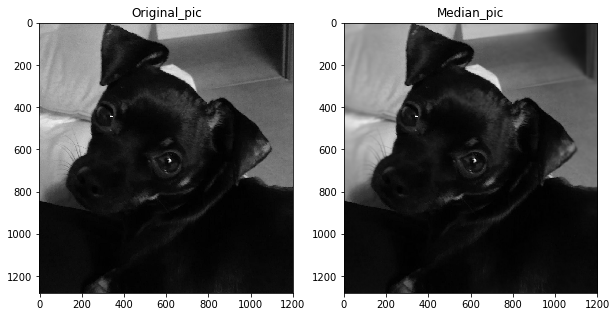

In [0]:
show_diff_pics()

# 7. Интегральные изображения

In [0]:
def get_filtered_pics(k=5):
    integral_pic = cv.integral(gray_pic)
    filtered_pic = np.zeros(shape=[height,width,3], dtype=np.uint8)

    for y in range(0, height):
        for x in range(0, width):
            window_radius = k * normalized_pic[y, x]
            r = window_radius

            x1 = integral_pic[bounded(y - r, 0, height - 1), bounded(x - r, 0, width - 1)]
            x2 = integral_pic[bounded(y - r, 0, height - 1), bounded(x + r, 0, width - 1)]
            x3 = integral_pic[bounded(y + r, 0, height - 1), bounded(x + r, 0, width - 1)]
            x4 = integral_pic[bounded(y + r, 0, height - 1), bounded(x - r, 0, width - 1)]

            sum_ = x1 + x3 - x2 - x4
            ave = (2 * window_radius + 1) ** 2
            filtered_pic[y, x] = (sum_ / ave)
    return filtered_pic
  
def show_filtered_pics():
  fig, (x1, x2, x3, x4, x5) = plt.subplots(1, 5, figsize=(10,10))

  x1.set_title('Original')
  x1.imshow(gray_pic, cmap='gray')

  x2.set_title('Filtering 1')
  x2.imshow(get_filtered_pics(0.5), cmap='gray')

  x3.set_title('Filtering 2')
  x3.imshow(get_filtered_pics(5), cmap='gray')

  x4.set_title('Filtering 3')
  x4.imshow(get_filtered_pics(50), cmap='gray')

  x5.set_title('Integral image')
  integral_pic = cv.integral(gray_pic)
  x5.imshow(integral_pic, cmap='gray')

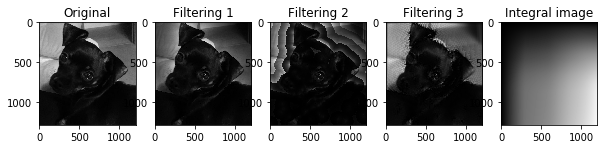

In [0]:
show_filtered_pics()